**Домашнее задание №2** - Латентное пространство в VAE автоенкодере

Прочитайте внимательно статью "Variational Autoencoders are Beautiful":

https://www.compthree.com/blog/autoencoder/

В данном задании необходимо:

1) реализовать VAE автоенкодер с архитектурой как на рисунке:
<img src='mnist_vae.png' width=500>

2) Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_cloud.png' width=500>

3) Наконец, построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_digits.png' width=500>

Для реализации VAE автоенкодера воспользуйтесь кодом ниже:

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 250
z_dim = 2
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

c:\users\fufai\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\users\fufai\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\users\fufai\appdata\local\programs\python\python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [10/469], Reconst Loss: 34863.7812, KL Div: 834.3248
Epoch[1/15], Step [20/469], Reconst Loss: 28688.2148, KL Div: 1223.9860
Epoch[1/15], Step [30/469], Reconst Loss: 27427.1602, KL Div: 703.8078
Epoch[1/15], Step [40/469], Reconst Loss: 26045.2754, KL Div: 665.6356
Epoch[1/15], Step [50/469], Reconst Loss: 26123.3867, KL Div: 653.6000
Epoch[1/15], Step [60/469], Reconst Loss: 26703.8340, KL Div: 660.1540
Epoch[1/15], Step [70/469], Reconst Loss: 26050.2695, KL Div: 658.0695
Epoch[1/15], Step [80/469], Reconst Loss: 25099.2266, KL Div: 682.4976
Epoch[1/15], Step [90/469], Reconst Loss: 25246.0371, KL Div: 794.2014
Epoch[1/15], Step [100/469], Reconst Loss: 24280.9688, KL Div: 729.4265
Epoch[1/15], Step [110/469], Reconst Loss: 22415.3828, KL Div: 812.4464
Epoch[1/15], Step [120/469], Reconst Loss: 23796.6406, KL Div: 747.3049
Epoch[1/15], Step [130/469], Reconst Loss: 24056.0449, KL Div: 688.2200
Epoch[1/15], Step [140/469], Reconst Loss: 22525.6094, KL Div: 753.5667


Epoch[3/15], Step [250/469], Reconst Loss: 20076.9844, KL Div: 665.5629
Epoch[3/15], Step [260/469], Reconst Loss: 19504.2617, KL Div: 662.5487
Epoch[3/15], Step [270/469], Reconst Loss: 20503.0781, KL Div: 656.5666
Epoch[3/15], Step [280/469], Reconst Loss: 19900.0352, KL Div: 684.8298
Epoch[3/15], Step [290/469], Reconst Loss: 20664.2910, KL Div: 628.1738
Epoch[3/15], Step [300/469], Reconst Loss: 20211.4043, KL Div: 651.7961
Epoch[3/15], Step [310/469], Reconst Loss: 20689.5449, KL Div: 625.5440
Epoch[3/15], Step [320/469], Reconst Loss: 20387.7383, KL Div: 619.7965
Epoch[3/15], Step [330/469], Reconst Loss: 18911.3984, KL Div: 704.9612
Epoch[3/15], Step [340/469], Reconst Loss: 19365.6328, KL Div: 717.1594
Epoch[3/15], Step [350/469], Reconst Loss: 20775.8516, KL Div: 627.3205
Epoch[3/15], Step [360/469], Reconst Loss: 20343.1035, KL Div: 658.9086
Epoch[3/15], Step [370/469], Reconst Loss: 21229.9805, KL Div: 668.5092
Epoch[3/15], Step [380/469], Reconst Loss: 21408.4609, KL Div: 6

Epoch[6/15], Step [30/469], Reconst Loss: 20312.1895, KL Div: 679.9040
Epoch[6/15], Step [40/469], Reconst Loss: 20257.6387, KL Div: 689.4417
Epoch[6/15], Step [50/469], Reconst Loss: 19375.1621, KL Div: 692.0163
Epoch[6/15], Step [60/469], Reconst Loss: 19203.2344, KL Div: 676.6483
Epoch[6/15], Step [70/469], Reconst Loss: 19314.8750, KL Div: 682.2513
Epoch[6/15], Step [80/469], Reconst Loss: 20070.4316, KL Div: 704.6761
Epoch[6/15], Step [90/469], Reconst Loss: 19804.3164, KL Div: 710.7255
Epoch[6/15], Step [100/469], Reconst Loss: 20411.0117, KL Div: 671.9665
Epoch[6/15], Step [110/469], Reconst Loss: 19618.8398, KL Div: 721.0854
Epoch[6/15], Step [120/469], Reconst Loss: 19652.2285, KL Div: 668.4345
Epoch[6/15], Step [130/469], Reconst Loss: 18757.4570, KL Div: 760.0408
Epoch[6/15], Step [140/469], Reconst Loss: 18964.2656, KL Div: 677.0258
Epoch[6/15], Step [150/469], Reconst Loss: 18919.2148, KL Div: 718.2706
Epoch[6/15], Step [160/469], Reconst Loss: 19375.7461, KL Div: 696.4860

Epoch[8/15], Step [270/469], Reconst Loss: 20205.6641, KL Div: 694.1926
Epoch[8/15], Step [280/469], Reconst Loss: 19125.0234, KL Div: 714.9613
Epoch[8/15], Step [290/469], Reconst Loss: 20382.5293, KL Div: 679.5988
Epoch[8/15], Step [300/469], Reconst Loss: 19483.2520, KL Div: 705.3947
Epoch[8/15], Step [310/469], Reconst Loss: 20716.4473, KL Div: 699.1989
Epoch[8/15], Step [320/469], Reconst Loss: 20378.2031, KL Div: 691.7572
Epoch[8/15], Step [330/469], Reconst Loss: 18243.4844, KL Div: 728.6603
Epoch[8/15], Step [340/469], Reconst Loss: 19368.7500, KL Div: 726.8002
Epoch[8/15], Step [350/469], Reconst Loss: 19157.8496, KL Div: 709.3372
Epoch[8/15], Step [360/469], Reconst Loss: 19799.8086, KL Div: 673.2261
Epoch[8/15], Step [370/469], Reconst Loss: 17844.7480, KL Div: 722.6183
Epoch[8/15], Step [380/469], Reconst Loss: 19510.5488, KL Div: 677.7775
Epoch[8/15], Step [390/469], Reconst Loss: 19564.7129, KL Div: 700.4612
Epoch[8/15], Step [400/469], Reconst Loss: 20667.0312, KL Div: 6

Epoch[11/15], Step [30/469], Reconst Loss: 17646.4336, KL Div: 758.3603
Epoch[11/15], Step [40/469], Reconst Loss: 19152.0332, KL Div: 751.5733
Epoch[11/15], Step [50/469], Reconst Loss: 19695.0312, KL Div: 716.6207
Epoch[11/15], Step [60/469], Reconst Loss: 19041.1836, KL Div: 725.6830
Epoch[11/15], Step [70/469], Reconst Loss: 18563.7773, KL Div: 731.7546
Epoch[11/15], Step [80/469], Reconst Loss: 18948.0332, KL Div: 736.6646
Epoch[11/15], Step [90/469], Reconst Loss: 18795.7773, KL Div: 724.6305
Epoch[11/15], Step [100/469], Reconst Loss: 19154.7109, KL Div: 722.1305
Epoch[11/15], Step [110/469], Reconst Loss: 18961.9570, KL Div: 731.5970
Epoch[11/15], Step [120/469], Reconst Loss: 19524.3945, KL Div: 762.0594
Epoch[11/15], Step [130/469], Reconst Loss: 18632.3047, KL Div: 713.6182
Epoch[11/15], Step [140/469], Reconst Loss: 19426.2559, KL Div: 701.5699
Epoch[11/15], Step [150/469], Reconst Loss: 19718.6094, KL Div: 728.0846
Epoch[11/15], Step [160/469], Reconst Loss: 20218.5586, KL

Epoch[13/15], Step [250/469], Reconst Loss: 19559.9922, KL Div: 727.2391
Epoch[13/15], Step [260/469], Reconst Loss: 18009.7031, KL Div: 760.3115
Epoch[13/15], Step [270/469], Reconst Loss: 18996.4414, KL Div: 744.3412
Epoch[13/15], Step [280/469], Reconst Loss: 18414.3750, KL Div: 738.1119
Epoch[13/15], Step [290/469], Reconst Loss: 19641.1250, KL Div: 752.1898
Epoch[13/15], Step [300/469], Reconst Loss: 19207.2520, KL Div: 732.2851
Epoch[13/15], Step [310/469], Reconst Loss: 18135.4277, KL Div: 779.3439
Epoch[13/15], Step [320/469], Reconst Loss: 19452.9688, KL Div: 762.7302
Epoch[13/15], Step [330/469], Reconst Loss: 18764.1992, KL Div: 761.3497
Epoch[13/15], Step [340/469], Reconst Loss: 19191.9648, KL Div: 722.4439
Epoch[13/15], Step [350/469], Reconst Loss: 18606.8867, KL Div: 764.6392
Epoch[13/15], Step [360/469], Reconst Loss: 18738.8945, KL Div: 722.7222
Epoch[13/15], Step [370/469], Reconst Loss: 18627.7773, KL Div: 737.4739
Epoch[13/15], Step [380/469], Reconst Loss: 18824.7

torch.Size([420, 420])


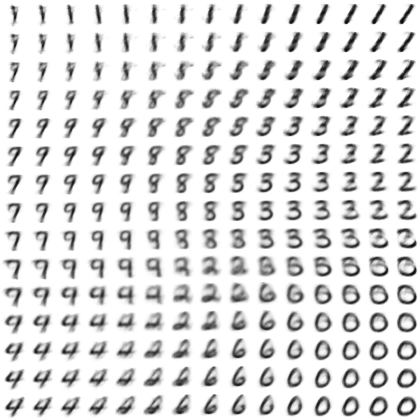

In [2]:
# Вывод циферок
toImage = transforms.ToPILImage()
z = torch.Tensor([1,2])

left_up = [-2, 2]
steps = 15
length = 2*abs(left_up[0])/steps

line = ()
image = ()
for j in range(0, steps):
    for i in range(0, steps):
        z[0] = left_up[0] + length*i
        z[1] = left_up[1] - length*j
        x = model.decode(z)
        x = x.view(28,28)
        line = line + (x,)
    image = image + (torch.cat(line, 1),)
    line = ()

tensor_image = torch.cat(image, 0)    
print(tensor_image.shape)


from PIL import Image
import PIL.ImageOps
new_image = toImage(tensor_image)
inverted_image = PIL.ImageOps.invert(new_image)
inverted_image

Text(0.5, 1.0, 'Trial plot')

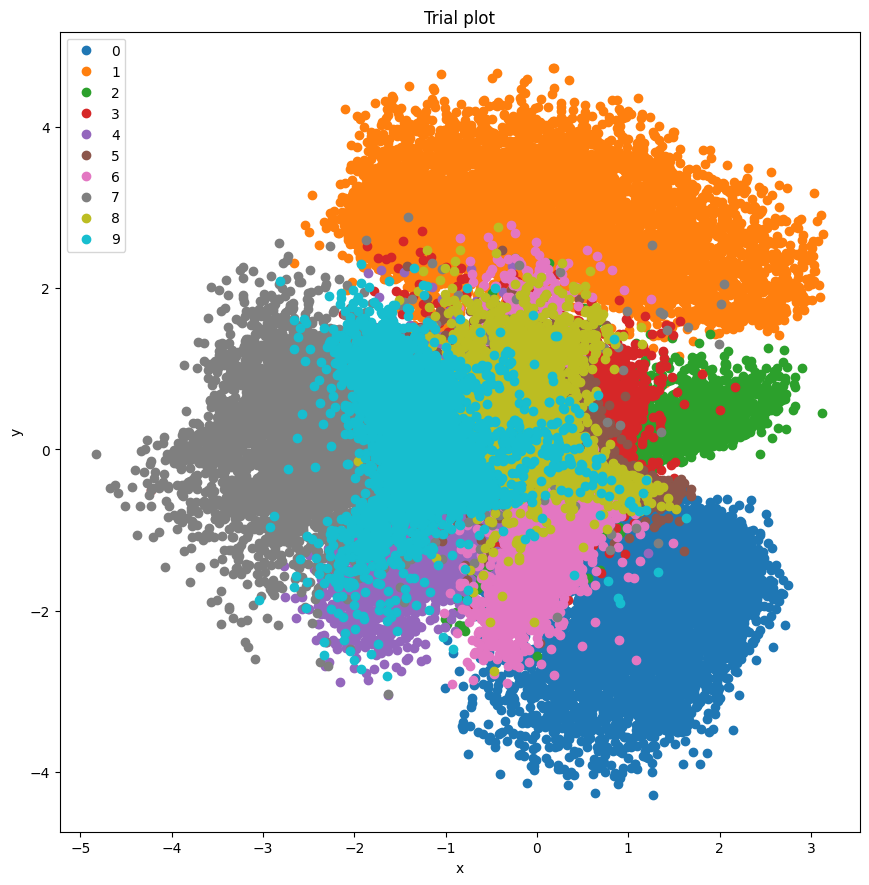

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


# Data loader
plot_data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                               shuffle=True)

x = [[],[],[],[],[],[],[],[],[],[]]
y = [[],[],[],[],[],[],[],[],[],[]]
#legend = ['dark-red', 'red', 'light-red', 'orange', 'yellow', 'green', 'light-blue', 'blue', 'violet', 'purple']
#legend = {'0':'dark-red', '1':'red', '2':'light-red', '3':'orange', '4':'yellow', '5':'green', '6':'light-blue', 7:'blue', 8:'violet', 9:'purple'}
legend = [0,1,2,3,4,5,6,7,8,9]

for i, (x_en, a) in enumerate(plot_data_loader):
        # Forward pass
        x_en = x_en.to(device).view(-1, image_size)
        mu, log_var = model.encode(x_en)
        z = model.reparameterize(mu, log_var)
        for j in range(0, len(z)):
            x[a.item()].append(z[j][0].item())
            y[a.item()].append(z[j][1].item())
        
#x = np.linspace(-10, 10, 50)
#y = np.linspace(123, 562, 50)

fig = plt.figure(figsize=(10, 10))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for j in range(0, 10):
    axes.plot(x[j],y[j], 'o')
axes.legend(legend)

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Trial plot')
#axes.legend([r'$x^2$', 'x^3'], loc = 0)